In [1]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt

In [16]:
class MeteoReader:

    def __init__(self, station_code:str, place_code: str, base_url: str= "https://api.meteo.lt/v1"):
        self.station_code=station_code
        self.place_code=place_code
        self.base_url = base_url
    
    def get_history(self, date_from:str, date_to:str)->pd.DataFrame:
        dates=pd.date_range(date_from, date_to, freq="D")
        frames=[]

        for d in dates:
            url = f"{self.base_url}/stations/{self.station_code}/observations/{d.date()}"
            #print(d.date())
            r = requests.get(url)
            if r.status_code != 200:
                print(f"Klaida gaunant duomenis {d.date()}: {r.status_code}")
                continue
            #nes site sake kad 180 per minute   
            time.sleep(0.5)

            data = r.json().get("observations", [])
            if not data:
                continue

            df = pd.DataFrame(data)
            df["time"] = pd.to_datetime(df["observationTimeUtc"], utc=True)
            df = df.set_index("time").drop(columns=["observationTimeUtc"])
            frames.append(df)

        return pd.concat(frames).sort_index() if frames else pd.DataFrame()

    def get_forecast(self, forecast_type: str = "long-term") -> pd.DataFrame:
        url = f"{self.base_url}/places/{self.place_code}/forecasts/{forecast_type}"
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()
        df = pd.DataFrame(data.get("forecastTimestamps", []))
        df["time"] = pd.to_datetime(df["forecastTimeUtc"], utc=True)
        df = df.set_index("time").drop(columns=["forecastTimeUtc"])
        return df        
       

In [17]:
reader = MeteoReader(station_code="vilniaus-ams", place_code="vilnius")

print("Istoriniai duomenys:")
history_df = reader.get_history("2024-08-28", "2025-08-28")
print(history_df.head())
print("Forecastas:")
forecast_df = reader.get_forecast("long-term")
print(forecast_df.head())

Istoriniai duomenys:
                           airTemperature  feelsLikeTemperature  windSpeed  \
time                                                                         
2024-08-28 00:00:00+00:00            14.4                  14.4        1.2   
2024-08-28 01:00:00+00:00            14.2                  14.2        1.7   
2024-08-28 02:00:00+00:00            13.6                  13.6        1.6   
2024-08-28 03:00:00+00:00            13.2                  13.2        1.9   
2024-08-28 04:00:00+00:00            13.5                  13.5        1.8   

                           windGust  windDirection  cloudCover  \
time                                                             
2024-08-28 00:00:00+00:00       2.8            349         0.0   
2024-08-28 01:00:00+00:00       3.4             17         0.0   
2024-08-28 02:00:00+00:00       3.4            357         0.0   
2024-08-28 03:00:00+00:00       3.7             19         0.0   
2024-08-28 04:00:00+00:00       4.3 

In [31]:
#2 uzd-------------------------------------------------------------
history_lt = history_df.tz_convert("Europe/Vilnius")
forecast_lt=forecast_df.tz_convert("Europe/Vilnius")

#A:
print("Oro ir dregmes vidurkiai:")
means=history_lt[["airTemperature", "relativeHumidity"]].mean()
print(means)

#B:
history_lt["hour"] = history_lt.index.hour
history_lt["day_or_night"] = history_lt["hour"].apply(lambda h: "day" if 8 <= h < 20 else "night")
day_mean = history_lt[history_lt["day_or_night"] == "day"]["airTemperature"].mean()
night_mean = history_lt[history_lt["day_or_night"] == "night"]["airTemperature"].mean()

print(f"Vidutinė dienos temperatūra: {day_mean:.2f} °C")
print(f"Vidutinė nakties temperatūra: {night_mean:.2f} °C")

#C:
history_lt["is_rain"] = history_lt["precipitation"] > 0

history_lt["date"] = history_lt.index.normalize()
history_lt["weekday"] = history_lt.index.weekday 
rain_weekend_days = history_lt[(history_lt["is_rain"]) & (history_lt["weekday"] >= 5)]["date"].unique()
rain_weekend_series = pd.Series(rain_weekend_days)
num_rainy_weekends = len(rain_weekend_series.dt.to_period('W').unique())
print(f"Savaitgalių, kai lijo: {num_rainy_weekends}")


Oro ir dregmes vidurkiai:
airTemperature       8.620328
relativeHumidity    78.507696
dtype: float64
Vidutinė dienos temperatūra: 10.09 °C
Vidutinė nakties temperatūra: 7.15 °C
Savaitgalių, kai lijo: 34


C:\Users\matas\AppData\Local\Temp\ipykernel_9960\2467838732.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  num_rainy_weekends = len(rain_weekend_series.dt.to_period('W').unique())


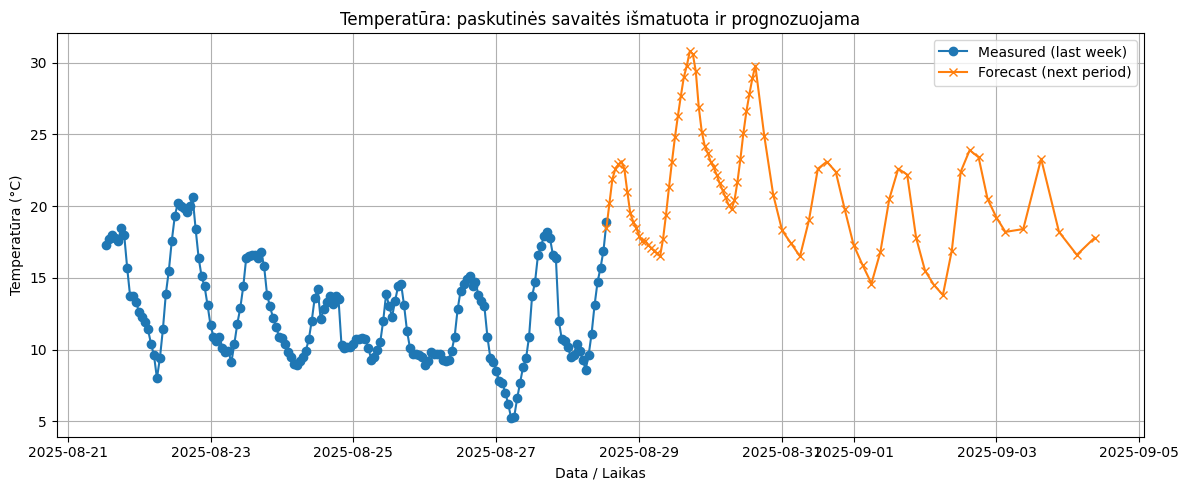

In [34]:
#3uzd:
last_week_start = history_lt.index.max() - pd.Timedelta(days=7)
last_week = history_lt[history_lt.index >= last_week_start]
history_temp = last_week["airTemperature"].rename("Measured")
forecast_temp = forecast_lt["airTemperature"].rename("Forecast")
combined = pd.concat([history_temp, forecast_temp])
plt.figure(figsize=(12,5))
plt.plot(history_temp.index, history_temp, label="Measured (last week)", marker='o')
plt.plot(forecast_temp.index, forecast_temp, label="Forecast (next period)", marker='x')
plt.title("Temperatūra: paskutinės savaitės išmatuota ir prognozuojama")
plt.xlabel("Data / Laikas")
plt.ylabel("Temperatūra (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
#4uzd:
def interpolate_to_5min(series: pd.Series) -> pd.Series:
    new_index = pd.date_range(start=series.index.min(),
                              end=series.index.max(),
                              freq='5T',
                              tz=series.index.tz)
    
    series_5min = series.reindex(new_index)
    series_5min = series_5min.interpolate(method='time')
    return series_5min

# Paskutine savaite
last_week_temp = history_lt["airTemperature"].last("7D")
temp_5min = interpolate_to_5min(last_week_temp)

print(temp_5min.head(50))

2025-08-21 14:00:00+03:00    17.700000
2025-08-21 14:05:00+03:00    17.725000
2025-08-21 14:10:00+03:00    17.750000
2025-08-21 14:15:00+03:00    17.775000
2025-08-21 14:20:00+03:00    17.800000
2025-08-21 14:25:00+03:00    17.825000
2025-08-21 14:30:00+03:00    17.850000
2025-08-21 14:35:00+03:00    17.875000
2025-08-21 14:40:00+03:00    17.900000
2025-08-21 14:45:00+03:00    17.925000
2025-08-21 14:50:00+03:00    17.950000
2025-08-21 14:55:00+03:00    17.975000
2025-08-21 15:00:00+03:00    18.000000
2025-08-21 15:05:00+03:00    17.983333
2025-08-21 15:10:00+03:00    17.966667
2025-08-21 15:15:00+03:00    17.950000
2025-08-21 15:20:00+03:00    17.933333
2025-08-21 15:25:00+03:00    17.916667
2025-08-21 15:30:00+03:00    17.900000
2025-08-21 15:35:00+03:00    17.883333
2025-08-21 15:40:00+03:00    17.866667
2025-08-21 15:45:00+03:00    17.850000
2025-08-21 15:50:00+03:00    17.833333
2025-08-21 15:55:00+03:00    17.816667
2025-08-21 16:00:00+03:00    17.800000
2025-08-21 16:05:00+03:00

C:\Users\matas\AppData\Local\Temp\ipykernel_9960\3851153688.py:13: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_week_temp = history_lt["airTemperature"].last("7D")
C:\Users\matas\AppData\Local\Temp\ipykernel_9960\3851153688.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(start=series.index.min(),
